In [ ]:
%pip install pandas 
 

# Loading Library

In [1]:
# 기본라이브러리 import
#from google.colab import drive
#import os, json, pickle
#import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# 파이토치 라이브러리 import
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

#Keras Import
import tensorflow as tf
from tensorflow.keras import layers
from datetime import timedelta, datetime

# 데이터 정규화
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings(action='ignore')

import ipaddress

# 구글 드라이브 mount
#drive.mount('/content/gdrive')

# 데이터 파일 위치
#C:\Users\mariu\내 드라이브\Colab Notebooks\Network
colab_path = '/home/marius1406/'
colab_write_path = "/home/marius1406/"

2023-10-11 17:50:56.013826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [2]:
colab_path = "/home/marius1406/"
df = pd.read_csv(colab_path+"NF-UQ-NIDS-total.csv",index_col=False, nrows=1089999)
#df = pd.read_csv(colab_path+"NF-UQ-NIDS-total.csv",index_col=False)

In [3]:
# 확장판에서 사용
#cols = df.columns.drop(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'DNS_QUERY_ID','Label','Attack','Dataset'])  #명목형변수, 레이블 변수 제외
#cols = df.columns.drop(['IPV4_SRC_ADDR_1','IPV4_SRC_ADDR_2','Label','Attack','Dataset', 'Label_1','Attack_1','Dataset_1', 'Label_2','Attack_2','Dataset_2'])  #명목형변수, 레이블 변수 제외
cols = df.columns.drop(['Label','Attack'])  #명목형변수, 레이블 변수 제외#cols = df.columns.drop(['Attack','Dataset'])  #명목형변수, 레이블 변수 제외
X = df[cols]
dummies = pd.get_dummies(df['Attack']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
Y = dummies.values

#==================
dummiesLabel = pd.get_dummies(df['Label']) # Classification
y_1_label = df['Label'].values
y_label = dummiesLabel.values

#import pandas as pd
#import numpy as np

def extend_sparse(val):
    if val in ['Analysis', 'Exploits', 'Fuzzers', 'Shellcode', 'Theft', 'Worms', 'mitm']: return 1
    return 0

y_1_attack = pd.DataFrame(df['Attack'])

is_sparse = y_1_attack.applymap(extend_sparse)
y_1_enforce = is_sparse.values
y_enforce = pd.get_dummies(is_sparse['Attack']) # Classification

#=======================

def max_8G(val):
    if (val > 1.0e+9): return 1.0e+9
    return val

#cols =['DST_TO_SRC_SECOND_BYTES', 'SRC_TO_DST_SECOND_BYTES', 'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT']
cols =['DST_TO_SRC_SECOND_BYTES', 'SRC_TO_DST_SECOND_BYTES', 'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
'DST_TO_SRC_SECOND_BYTES_1', 'SRC_TO_DST_SECOND_BYTES_1', 'SRC_TO_DST_AVG_THROUGHPUT_1', 'DST_TO_SRC_AVG_THROUGHPUT_1',
'DST_TO_SRC_SECOND_BYTES_2', 'SRC_TO_DST_SECOND_BYTES_2', 'SRC_TO_DST_AVG_THROUGHPUT_2', 'DST_TO_SRC_AVG_THROUGHPUT_2'] 

X[cols] = X[cols].applymap(max_8G)

In [4]:
for col in X.columns:
    print(col , X[col].max())

IPV4_SRC_ADDR 4291722866
L4_SRC_PORT 65535
IPV4_DST_ADDR 4294967295
L4_DST_PORT 65535
PROTOCOL 254
L7_PROTO 248.0
IN_BYTES 34641563
IN_PKTS 123763
OUT_BYTES 129573662
OUT_PKTS 87179
TCP_FLAGS 223
CLIENT_TCP_FLAGS 223
SERVER_TCP_FLAGS 223
FLOW_DURATION_MILLISECONDS 4294967
DURATION_IN 105400
DURATION_OUT 38547
MIN_TTL 255
MAX_TTL 255
LONGEST_FLOW_PKT 7292
SHORTEST_FLOW_PKT 1504
MIN_IP_PKT_LEN 547
MAX_IP_PKT_LEN 7292
SRC_TO_DST_SECOND_BYTES 1000000000.0
DST_TO_SRC_SECOND_BYTES 1000000000.0
RETRANSMITTED_IN_BYTES 6321251
RETRANSMITTED_IN_PKTS 4774
RETRANSMITTED_OUT_BYTES 2183347
RETRANSMITTED_OUT_PKTS 1458
SRC_TO_DST_AVG_THROUGHPUT 1000000000.0
DST_TO_SRC_AVG_THROUGHPUT 1000000000.0
NUM_PKTS_UP_TO_128_BYTES 191858
NUM_PKTS_128_TO_256_BYTES 7230
NUM_PKTS_256_TO_512_BYTES 4921
NUM_PKTS_512_TO_1024_BYTES 34443
NUM_PKTS_1024_TO_1514_BYTES 86096
TCP_WIN_MAX_IN 65535
TCP_WIN_MAX_OUT 65535
ICMP_TYPE 65280
ICMP_IPV4_TYPE 255
DNS_QUERY_ID 65535
DNS_QUERY_TYPE 32769
DNS_TTL_ANSWER 4294915672
FTP_CO

# Normalize Data

In [5]:
# 데이터 정규화
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


scaler_train = preprocessing.StandardScaler()
scaler_train = scaler_train.fit(X)
X = pd.DataFrame(scaler_train.transform(X),index=np.arange(0,X.shape[0],1), columns = X.columns)


In [6]:
for col in X.columns:
    print(col , X[col].isna().sum())
X.isna().sum().sum()

IPV4_SRC_ADDR 0
L4_SRC_PORT 0
IPV4_DST_ADDR 0
L4_DST_PORT 0
PROTOCOL 0
L7_PROTO 0
IN_BYTES 0
IN_PKTS 0
OUT_BYTES 0
OUT_PKTS 0
TCP_FLAGS 0
CLIENT_TCP_FLAGS 0
SERVER_TCP_FLAGS 0
FLOW_DURATION_MILLISECONDS 0
DURATION_IN 0
DURATION_OUT 0
MIN_TTL 0
MAX_TTL 0
LONGEST_FLOW_PKT 0
SHORTEST_FLOW_PKT 0
MIN_IP_PKT_LEN 0
MAX_IP_PKT_LEN 0
SRC_TO_DST_SECOND_BYTES 0
DST_TO_SRC_SECOND_BYTES 0
RETRANSMITTED_IN_BYTES 0
RETRANSMITTED_IN_PKTS 0
RETRANSMITTED_OUT_BYTES 0
RETRANSMITTED_OUT_PKTS 0
SRC_TO_DST_AVG_THROUGHPUT 0
DST_TO_SRC_AVG_THROUGHPUT 0
NUM_PKTS_UP_TO_128_BYTES 0
NUM_PKTS_128_TO_256_BYTES 0
NUM_PKTS_256_TO_512_BYTES 0
NUM_PKTS_512_TO_1024_BYTES 0
NUM_PKTS_1024_TO_1514_BYTES 0
TCP_WIN_MAX_IN 0
TCP_WIN_MAX_OUT 0
ICMP_TYPE 0
ICMP_IPV4_TYPE 0
DNS_QUERY_ID 0
DNS_QUERY_TYPE 0
DNS_TTL_ANSWER 0
FTP_COMMAND_RET_CODE 0
L4_SRC_PORT_1 0
IPV4_DST_ADDR_1 0
L4_DST_PORT_1 0
PROTOCOL_1 0
L7_PROTO_1 0
IN_BYTES_1 0
IN_PKTS_1 0
OUT_BYTES_1 0
OUT_PKTS_1 0
TCP_FLAGS_1 0
CLIENT_TCP_FLAGS_1 0
SERVER_TCP_FLAGS_1 0
FLO

0

In [7]:
def max_3sigma(val):
    if (val < -3): return -3
    if (val > 3): return 3
    return val

X = X.applymap(max_3sigma)

In [8]:
y1 = tf.argmax(dummies, axis=1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle = True, random_state=33)
x_train, x_test_label, y_train_label, y_test_label = train_test_split(X, y_label, test_size=0.20, shuffle = True, random_state=33)
x_train, x_test_enforce, y_train_enforce, y_test_enforce = train_test_split(X, y_enforce, test_size=0.20, shuffle = True, random_state=33)
x_train, x_test_1, y_train_1, y_test_1 = train_test_split(X, y1.numpy(), test_size=0.20, shuffle = True, random_state=33)

2023-10-11 17:51:33.081303: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
from collections import Counter
#type(y_train)
ydp= pd.DataFrame(y_train)
ydp = tf.argmax(ydp, axis=1)
#ydp = pd.DataFrame(ydp)
#ydp.value_counts
dicts = Counter(ydp.numpy())
dicts



Counter({6: 205290,
         2: 288786,
         5: 249311,
         20: 28278,
         19: 43885,
         11: 29889,
         17: 13051,
         3: 1639,
         15: 7863,
         4: 1436,
         10: 1354,
         8: 256,
         9: 185,
         7: 373,
         18: 31,
         1: 214,
         13: 17,
         16: 86,
         0: 38,
         12: 13,
         14: 4})

# Model Train

In [17]:
colab_write_path = "/home/marius1406/"
colab_model_write_path = colab_write_path + datetime.now().strftime("%Y%m%d%H%M" + "/")

In [18]:
#model1
#initializer = "glorot_uniform"
initializer = tf.keras.initializers.GlorotUniform(seed=33)
constraints = None


model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints, activation='relu',name='dense_1a'),
  tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu',name='dense_1b'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu',name='dense_1c'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu',name='dense_1d'),
  tf.keras.layers.Dense(Y.shape[1],activation='softmax')
  ])
'''
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints, activation='relu'),
  tf.keras.layers.Dense(128, input_dim=64, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, input_dim=128, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64, input_dim=128, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
  tf.keras.layers.Dense(Y.shape[1],input_dim=64, activation='softmax')
  ])
'''

'\nmodel_1 = tf.keras.Sequential([\n  tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints, activation=\'relu\'),\n  tf.keras.layers.Dense(128, input_dim=64, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation=\'relu\'),\n  tf.keras.layers.Dropout(0.3),\n  tf.keras.layers.Dense(128, input_dim=128, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation=\'relu\'),\n  tf.keras.layers.Dropout(0.3),\n  tf.keras.layers.Dense(64, input_dim=128, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation=\'relu\'),\n  tf.keras.layers.Dense(Y.shape[1],input_dim=64, activation=\'softmax\')\n  ])\n'

In [19]:
#model 1
model_1.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir_1 = colab_write_path + datetime.now().strftime("%Y%m%d%H%M%S")
print(log_dir_1)
monitor_1 = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=8, verbose=1, mode='auto',restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir_1, histogram_freq=1)
            ]
history_1  = model_1.fit(x_train,y_train,validation_data=(x_test,y_test), verbose=2, batch_size=1024, epochs=100)
model_1.save(colab_model_write_path + 'model1.h5')
#history_1  = model_1.fit(x_train,y_train,validation_split=0.2, callbacks=[monitor_1],verbose=2, batch_size=1024, epochs=100)


/home/marius1406/20231010221352
Epoch 1/100
852/852 - 10s - loss: 0.2878 - accuracy: 0.9140 - val_loss: 0.1270 - val_accuracy: 0.9654 - 10s/epoch - 12ms/step
Epoch 2/100
852/852 - 20s - loss: 0.1290 - accuracy: 0.9653 - val_loss: 0.1031 - val_accuracy: 0.9727 - 20s/epoch - 23ms/step
Epoch 3/100
852/852 - 11s - loss: 0.1105 - accuracy: 0.9708 - val_loss: 0.0938 - val_accuracy: 0.9753 - 11s/epoch - 13ms/step
Epoch 4/100
852/852 - 14s - loss: 0.1012 - accuracy: 0.9734 - val_loss: 0.0869 - val_accuracy: 0.9771 - 14s/epoch - 17ms/step
Epoch 5/100
852/852 - 15s - loss: 0.0947 - accuracy: 0.9749 - val_loss: 0.0852 - val_accuracy: 0.9774 - 15s/epoch - 18ms/step
Epoch 6/100
852/852 - 14s - loss: 0.0906 - accuracy: 0.9761 - val_loss: 0.0807 - val_accuracy: 0.9787 - 14s/epoch - 16ms/step
Epoch 7/100
852/852 - 17s - loss: 0.0876 - accuracy: 0.9767 - val_loss: 0.0793 - val_accuracy: 0.9792 - 17s/epoch - 19ms/step
Epoch 8/100
852/852 - 23s - loss: 0.0851 - accuracy: 0.9774 - val_loss: 0.0764 - val_a

In [20]:
#Training  model 2  with different structure
initializer = tf.keras.initializers.GlorotUniform(seed=33)
constraints = None

model_2 = tf.keras.Sequential([
      tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu',name='dense_2a'),
      tf.keras.layers.Dense(128, input_dim=64, kernel_initializer=initializer, activation='relu',name='dense_2b'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(256, input_dim=128, kernel_initializer=initializer, activation='relu',name='dense_2c'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, input_dim=256, kernel_initializer=initializer, activation='relu',name='dense_2d'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(Y.shape[1],activation='softmax')
      ])

In [21]:
#from tensorflow.keras.callbacks import EarlyStopping

model_2.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir_2 = colab_write_path + "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

monitor_2 = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=8, verbose=1, mode='auto',restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir_2, histogram_freq=1)
            ]
history_2  = model_2.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor_2],verbose=2, batch_size=512, epochs=100)
model_2.save(colab_model_write_path + 'model2.h5')

#history_2  = model_2.fit(x_train,y_train,validation_data=(x_test,y_test), verbose=2, batch_size=512, epochs=100)

Epoch 1/100
1704/1704 - 14s - loss: 0.2063 - accuracy: 0.9384 - val_loss: 0.1091 - val_accuracy: 0.9693 - 14s/epoch - 8ms/step
Epoch 2/100
1704/1704 - 15s - loss: 0.1104 - accuracy: 0.9704 - val_loss: 0.0928 - val_accuracy: 0.9750 - 15s/epoch - 9ms/step
Epoch 3/100
1704/1704 - 12s - loss: 0.0971 - accuracy: 0.9739 - val_loss: 0.0835 - val_accuracy: 0.9780 - 12s/epoch - 7ms/step
Epoch 4/100
1704/1704 - 16s - loss: 0.0902 - accuracy: 0.9760 - val_loss: 0.0814 - val_accuracy: 0.9785 - 16s/epoch - 9ms/step
Epoch 5/100
1704/1704 - 12s - loss: 0.0865 - accuracy: 0.9769 - val_loss: 0.0774 - val_accuracy: 0.9796 - 12s/epoch - 7ms/step
Epoch 6/100
1704/1704 - 13s - loss: 0.0833 - accuracy: 0.9778 - val_loss: 0.0785 - val_accuracy: 0.9796 - 13s/epoch - 7ms/step
Epoch 7/100
1704/1704 - 13s - loss: 0.0815 - accuracy: 0.9782 - val_loss: 0.0755 - val_accuracy: 0.9798 - 13s/epoch - 7ms/step
Epoch 8/100
1704/1704 - 12s - loss: 0.0793 - accuracy: 0.9787 - val_loss: 0.0725 - val_accuracy: 0.9802 - 12s/e

In [22]:
#3 rd model for stack
initializer = tf.keras.initializers.GlorotUniform(seed=33)
constraints = None

model_3 = tf.keras.Sequential([
      tf.keras.layers.Dense(512, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu',name='dense_3a'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(256, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu',name='dense_3b'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu',name='dense_3c'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu',name='dense_3d'),
      tf.keras.layers.Dense(Y.shape[1],activation='softmax')
      ])

In [23]:

model_3.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir = colab_write_path + "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

monitor_3 = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=8, verbose=2, mode='auto',restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
            ]
history_3  = model_3.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor_3],verbose=2, batch_size=512, epochs=100)
model_3.save(colab_model_write_path + 'model3.h5')

Epoch 1/100
1704/1704 - 22s - loss: 0.1728 - accuracy: 0.9499 - val_loss: 0.0947 - val_accuracy: 0.9748 - 22s/epoch - 13ms/step
Epoch 2/100
1704/1704 - 21s - loss: 0.1002 - accuracy: 0.9733 - val_loss: 0.0837 - val_accuracy: 0.9779 - 21s/epoch - 12ms/step
Epoch 3/100
1704/1704 - 22s - loss: 0.0899 - accuracy: 0.9761 - val_loss: 0.0802 - val_accuracy: 0.9786 - 22s/epoch - 13ms/step
Epoch 4/100
1704/1704 - 21s - loss: 0.0851 - accuracy: 0.9774 - val_loss: 0.0785 - val_accuracy: 0.9797 - 21s/epoch - 12ms/step
Epoch 5/100
1704/1704 - 22s - loss: 0.0819 - accuracy: 0.9781 - val_loss: 0.0752 - val_accuracy: 0.9803 - 22s/epoch - 13ms/step
Epoch 6/100
1704/1704 - 20s - loss: 0.0795 - accuracy: 0.9788 - val_loss: 0.0746 - val_accuracy: 0.9801 - 20s/epoch - 12ms/step
Epoch 7/100
1704/1704 - 20s - loss: 0.0770 - accuracy: 0.9792 - val_loss: 0.0728 - val_accuracy: 0.9806 - 20s/epoch - 12ms/step
Epoch 8/100
1704/1704 - 20s - loss: 0.0756 - accuracy: 0.9796 - val_loss: 0.0732 - val_accuracy: 0.9805 

In [24]:
#4 rd model for stack
initializer = tf.keras.initializers.GlorotUniform(seed=33)
constraints = None

model_4 = tf.keras.Sequential([
      tf.keras.layers.Dense(128, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_4a'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_4b'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(64, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_4c'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(128, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_4d'),
      tf.keras.layers.Dense(y_train.shape[1],activation='softmax')
      ])

In [25]:
model_4.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir_4 = colab_write_path + "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

monitor_4 = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=100, verbose=1, mode='auto',restore_best_weights=True),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir_4, histogram_freq=1)
        ]
history_4  = model_4.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor_4],verbose=2, batch_size=512, epochs=100)
model_4.save(colab_model_write_path + 'model4.h5')

Epoch 1/100
1704/1704 - 9s - loss: 0.2432 - accuracy: 0.9265 - val_loss: 0.1163 - val_accuracy: 0.9687 - 9s/epoch - 6ms/step
Epoch 2/100
1704/1704 - 9s - loss: 0.1272 - accuracy: 0.9651 - val_loss: 0.0988 - val_accuracy: 0.9741 - 9s/epoch - 5ms/step
Epoch 3/100
1704/1704 - 8s - loss: 0.1102 - accuracy: 0.9701 - val_loss: 0.0887 - val_accuracy: 0.9766 - 8s/epoch - 5ms/step
Epoch 4/100
1704/1704 - 9s - loss: 0.1018 - accuracy: 0.9725 - val_loss: 0.0856 - val_accuracy: 0.9776 - 9s/epoch - 5ms/step
Epoch 5/100
1704/1704 - 8s - loss: 0.0972 - accuracy: 0.9740 - val_loss: 0.0831 - val_accuracy: 0.9785 - 8s/epoch - 5ms/step
Epoch 6/100
1704/1704 - 8s - loss: 0.0933 - accuracy: 0.9749 - val_loss: 0.0786 - val_accuracy: 0.9794 - 8s/epoch - 5ms/step
Epoch 7/100
1704/1704 - 9s - loss: 0.0907 - accuracy: 0.9756 - val_loss: 0.0774 - val_accuracy: 0.9796 - 9s/epoch - 5ms/step
Epoch 8/100
1704/1704 - 12s - loss: 0.0891 - accuracy: 0.9760 - val_loss: 0.0768 - val_accuracy: 0.9797 - 12s/epoch - 7ms/ste

In [26]:
#5 rd model for stack
initializer = tf.keras.initializers.GlorotUniform(seed=33)
constraints = None

model_5 = tf.keras.Sequential([
      tf.keras.layers.Dense(256, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_5a'),
      tf.keras.layers.Dense(128, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_5b'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_5c'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_5d'),
      tf.keras.layers.Dense(y_train_enforce.shape[1],activation='softmax')
      ])

In [27]:
model_5.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir_5 = colab_write_path + "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

monitor_5 = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=100, verbose=1, mode='auto',restore_best_weights=True),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir_5, histogram_freq=1)
        ]
history_5  = model_5.fit(x_train,y_train_enforce,validation_data=(x_test,y_test_enforce), callbacks=[monitor_5],verbose=2, batch_size=512, epochs=100)
model_5.save(colab_model_write_path + 'model5.h5')

Epoch 1/100
1704/1704 - 11s - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0017 - val_accuracy: 0.9993 - 11s/epoch - 7ms/step
Epoch 2/100
1704/1704 - 10s - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 0.9993 - 10s/epoch - 6ms/step
Epoch 3/100
1704/1704 - 9s - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0018 - val_accuracy: 0.9994 - 9s/epoch - 6ms/step
Epoch 4/100
1704/1704 - 9s - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0019 - val_accuracy: 0.9994 - 9s/epoch - 5ms/step
Epoch 5/100
1704/1704 - 9s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 0.9994 - 9s/epoch - 5ms/step
Epoch 6/100
1704/1704 - 9s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 0.9994 - 9s/epoch - 5ms/step
Epoch 7/100
1704/1704 - 10s - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0022 - val_accuracy: 0.9994 - 10s/epoch - 6ms/step
Epoch 8/100
1704/1704 - 9s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0021 - val_accuracy: 0.9994 - 9s/epoch - 5ms

In [45]:
model_1.save(colab_model_write_path + 'model1_1.h5')
model_2.save(colab_model_write_path + 'model1_2.h5')
model_3.save(colab_model_write_path + 'model1_3.h5')
model_4.save(colab_model_write_path + 'model1_4.h5')
model_5.save(colab_model_write_path + 'model1_5.h5')


# Model 6 SMOTE

In [21]:
# from collections import Counter
# #type(y_train)
# ydp= pd.DataFrame(y_train)
# ydp = tf.argmax(ydp, axis=1)
# #ydp = pd.DataFrame(ydp)
# #ydp.value_counts
# dicts = Counter(ydp.numpy())
# dicts

# MININUM_SAMPLES = 30000
# MAXINUM_SAMPLES = 300000

# sample_dict = {2: 793860,
#          19: 119826,
#          6: 564661,
#          15: 21588,
#          20: 77352,
#          5: 687703,
#          4: 3987,
#          11: 82959,
#          17: 36318,
#          10: 3759,
#          7: 999,
#          9: 562,
#          3: 4605,
#          16: 233,
#          1: 592,
#          8: 710,
#          13: 71,
#          18: 92,
#          0: 74,
#          12: 45,
#          14: 4}

# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# #ros = RandomOverSampler(random_state=33)
# for i in range(21):
#   if sample_dict[i] >  MAXINUM_SAMPLES:
#     sample_dict[i] =  MAXINUM_SAMPLES


# for i in range(21):
#   if sample_dict[i] <  MININUM_SAMPLES:
#     sample_dict[i] =  MININUM_SAMPLES


In [23]:
# #print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train.shape, y_train.shape)
# sample_dict

{2: 300000,
 19: 119826,
 6: 300000,
 15: 30000,
 20: 77352,
 5: 300000,
 4: 30000,
 11: 82959,
 17: 36318,
 10: 30000,
 7: 30000,
 9: 30000,
 3: 30000,
 16: 30000,
 1: 30000,
 8: 30000,
 13: 30000,
 18: 30000,
 0: 30000,
 12: 30000,
 14: 30000}

In [42]:
# undersample_dict

{2: 300000,
 19: 119826,
 6: 300000,
 15: 21588,
 20: 77352,
 5: 300000,
 4: 3987,
 11: 82959,
 17: 36318,
 10: 3759,
 7: 999,
 9: 562,
 3: 4605,
 16: 233,
 1: 592,
 8: 710,
 13: 71,
 18: 92,
 0: 74,
 12: 45,
 14: 4}

In [9]:
from collections import Counter
#type(y_train)
ydp= pd.DataFrame(y_train)
ydp = tf.argmax(ydp, axis=1)
#ydp = pd.DataFrame(ydp)
#ydp.value_counts
dicts = Counter(ydp.numpy())
dicts

Counter({6: 205290,
         2: 288786,
         5: 249311,
         20: 28278,
         19: 43885,
         11: 29889,
         17: 13051,
         3: 1639,
         15: 7863,
         4: 1436,
         10: 1354,
         8: 256,
         9: 185,
         7: 373,
         18: 31,
         1: 214,
         13: 17,
         16: 86,
         0: 38,
         12: 13,
         14: 4})

In [12]:
#from imblearn.over_sampling import SMOTE
#smote = SMOTE(random_state=42)
#X_train_over,y_train_over = smote.fit_resample(x_train,y_train)
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE


MININUM_SAMPLES = 10000
MAXINUM_SAMPLES = 100000

# sample_dict = {5: 687357,
#          2: 794288,
#          19: 119905,
#          15: 21686,
#          6: 564557,
#          4: 4025,
#          11: 82731,
#          20: 77617,
#          17: 36205,
#          3: 4569,
#          10: 3752,
#          9: 542,
#          7: 968,
#          8: 694,
#          1: 575,
#          16: 239,
#          0: 81,
#          18: 94,
#          13: 69,
#          12: 42,
#          14: 4}

sample_dict = {6: 205290,
         2: 288786,
         5: 249311,
         20: 28278,
         19: 43885,
         11: 29889,
         17: 13051,
         3: 1639,
         15: 7863,
         4: 1436,
         10: 1354,
         8: 256,
         9: 185,
         7: 373,
         18: 31,
         1: 214,
         13: 17,
         16: 86,
         0: 38,
         12: 13,
         14: 4}

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#ros = RandomOverSampler(random_state=33)
for i in range(21):
  if sample_dict[i] >  MAXINUM_SAMPLES:
    sample_dict[i] =  MAXINUM_SAMPLES

ros = RandomUnderSampler(sampling_strategy = sample_dict, random_state=33)
X_train_under, y_train_under = ros.fit_resample(x_train, y_train)

# for i in range(21):
#   if sample_dict[i] <  16:
#     sample_dict[i] =  16

# ros = RandomOverSampler(sampling_strategy = sample_dict, random_state=33)
# X_train_over, y_train_over = ros.fit_resample(x_train, y_train)

for i in range(21):
  if sample_dict[i] <  MININUM_SAMPLES:
    sample_dict[i] =  MININUM_SAMPLES

ros = RandomOverSampler(sampling_strategy = sample_dict, random_state=33)
X_train_over, y_train_over = ros.fit_resample(X_train_under, y_train_under)

# sm = SMOTE(sampling_strategy = sample_dict, random_state=33)
# X_train_over, y_train_over = sm.fit_resample(X_train_over, y_train_over)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)


SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (871999, 127) (871999, 21)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (555103, 127) (555103, 21)


In [13]:
import gc


gc.collect()



0

In [15]:
#6 rd model for stack
initializer = tf.keras.initializers.GlorotUniform(seed=33)
constraints = None

#6 rd model for stack
model_6 = tf.keras.Sequential([
      tf.keras.layers.Dense(256, input_dim=X_train_over.shape[1], kernel_initializer=initializer, activation='relu',name='dense_6a'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, input_dim=X_train_over.shape[1], kernel_initializer=initializer, activation='relu',name='dense_6b'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, input_dim=X_train_over.shape[1], kernel_initializer=initializer, activation='relu',name='dense_6c'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(64, input_dim=X_train_over.shape[1], kernel_initializer=initializer, activation='relu',name='dense_6d'),
      tf.keras.layers.Dense(y_train_over.shape[1],activation='softmax')
      ])

In [16]:
model_6.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir_6 = colab_write_path + "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

monitor_6 = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=100, verbose=1, mode='auto',restore_best_weights=True),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir_6, histogram_freq=1)
        ]
history_6  = model_6.fit(X_train_over,y_train_over,validation_data=(x_test,y_test), callbacks=[monitor_6],verbose=2, batch_size=512, epochs=100)
model_6.save(colab_model_write_path + 'model1_6.h5')

Epoch 1/100
1085/1085 - 10s - loss: 0.4190 - accuracy: 0.8622 - val_loss: 0.1915 - val_accuracy: 0.9446 - 10s/epoch - 9ms/step
Epoch 2/100
1085/1085 - 8s - loss: 0.2273 - accuracy: 0.9269 - val_loss: 0.1437 - val_accuracy: 0.9617 - 8s/epoch - 8ms/step
Epoch 3/100
1085/1085 - 8s - loss: 0.1844 - accuracy: 0.9437 - val_loss: 0.1276 - val_accuracy: 0.9676 - 8s/epoch - 7ms/step
Epoch 4/100
1085/1085 - 9s - loss: 0.1657 - accuracy: 0.9494 - val_loss: 0.1276 - val_accuracy: 0.9701 - 9s/epoch - 8ms/step
Epoch 5/100
1085/1085 - 9s - loss: 0.1553 - accuracy: 0.9531 - val_loss: 0.1107 - val_accuracy: 0.9716 - 9s/epoch - 8ms/step
Epoch 6/100
1085/1085 - 8s - loss: 0.1465 - accuracy: 0.9555 - val_loss: 0.1217 - val_accuracy: 0.9720 - 8s/epoch - 7ms/step
Epoch 7/100
1085/1085 - 9s - loss: 0.1415 - accuracy: 0.9571 - val_loss: 0.1092 - val_accuracy: 0.9733 - 9s/epoch - 8ms/step
Epoch 8/100
1085/1085 - 8s - loss: 0.1382 - accuracy: 0.9581 - val_loss: 0.1119 - val_accuracy: 0.9725 - 8s/epoch - 7ms/ste

In [39]:
colab_model_write_path
model_6.save(colab_model_write_path + 'model1_6.h5')

# Ensemble Model
https://abstractask.tistory.com/105

Model #1, Model #2, Model #3, + OverSampling/UnderSampling

In [10]:
# load models from file
# for both logistic and nueral
def load_all_models(n_models):
	all_models = list()

	for i in range(n_models):
		# define filename for this ensemble
#		colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
		#model_4.save(colab_path + 'model4.h5')
		if i != 4 and i != 3: #Model4와 Binary 배제
			filename = colab_model_write_path + 'model1_' + str(i + 1) + '.h5'
			# load model from file
			model = load_model(filename,custom_objects=None)
			# add to list of members
			all_models.append(model)
			print('>loaded %s' % filename)
	return all_models

In [11]:
# define stacked model from multiple member input models
#neural

def define_stacked_model(members):
	initializer = tf.keras.initializers.GlorotUniform(seed=64)
	constraints = None

  # update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i + 1) + '_' + layer.name


	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	merge = Dense(128, kernel_initializer=initializer, activation='relu',name="dense_ea")(merge)
	merge = Dense(128, kernel_initializer=initializer, activation='relu',name="dense_eb")(merge)
	output = Dense(Y.shape[1], kernel_initializer=initializer, activation='softmax',name="dense_ec")(merge)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.summary()
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [12]:
# fit a stacked model
#neural
import datetime


#colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
log_dir = colab_write_path + "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

monitor_7= [
             tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
            ]

def fit_stacked_model(model, inputX, inputy_enc):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# encode output data
#	inputy_enc = to_categorical(inputy)
	# fit model
	history_7=model.fit(X, inputy_enc, epochs=7, verbose=2,callbacks=[monitor_7])

In [13]:
# make a prediction with a stacked model
#neural
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=2)

In [16]:
# load all models
#neural

colab_write_path = "/home/marius1406/"
colab_model_write_path = colab_write_path +"20231010221344/"

from keras.models import load_model
n_members = 6
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded /home/marius1406/20231010221344/model1_1.h5
>loaded /home/marius1406/20231010221344/model1_2.h5
>loaded /home/marius1406/20231010221344/model1_3.h5
>loaded /home/marius1406/20231010221344/model1_6.h5
Loaded 4 models


In [17]:
# define ensemble model
import matplotlib.pyplot as plt
#from keras.utils import plot_model
#neural
#from keras.layers.merge import concatenate
from keras.layers import concatenate
from keras.layers import Dense
from keras.models import Model
from tensorflow.keras.utils import plot_model

stacked_model = define_stacked_model(members)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_2a_input (InputLayer)    [(None, 127)]        0           []                               
                                                                                                  
 dense_3a_input (InputLayer)    [(None, 127)]        0           []                               
                                                                                                  
 dense_6a_input (InputLayer)    [(None, 127)]        0           []                               
                                                                                                  
 dense_1a_input (InputLayer)    [(None, 127)

 ensemble_3_dense_3a (Dense)    (None, 512)          65536       ['dense_3a_input[0][0]']         
                                                                                                  
 ensemble_4_dense_6a (Dense)    (None, 256)          32768       ['dense_6a_input[0][0]']         
                                                                                                  
 ensemble_1_dense_1a (Dense)    (None, 64)           8192        ['dense_1a_input[0][0]']         
                                                                                                  
 ensemble_2_dense_2b (Dense)    (None, 128)          8320        ['ensemble_2_dense_2a[0][0]']    
                                                                                                  
 ensemble_3_dropout_11 (Dropout  (None, 512)         0           ['ensemble_3_dense_3a[0][0]']    
 )                                                                                                
          

In [18]:
from keras.utils import to_categorical
fit_stacked_model(stacked_model, x_train,y_train)
stacked_model.save(colab_model_write_path + 'stacked_model_1.h5')

Epoch 1/7
27250/27250 - 84s - loss: 0.0657 - accuracy: 0.9838 - 84s/epoch - 3ms/step
Epoch 2/7
27250/27250 - 83s - loss: 0.0590 - accuracy: 0.9846 - 83s/epoch - 3ms/step
Epoch 3/7
27250/27250 - 86s - loss: 0.0584 - accuracy: 0.9847 - 86s/epoch - 3ms/step
Epoch 4/7
27250/27250 - 81s - loss: 0.0583 - accuracy: 0.9847 - 81s/epoch - 3ms/step
Epoch 5/7
27250/27250 - 82s - loss: 0.0580 - accuracy: 0.9846 - 82s/epoch - 3ms/step
Epoch 6/7
27250/27250 - 83s - loss: 0.0578 - accuracy: 0.9847 - 83s/epoch - 3ms/step
Epoch 7/7
27250/27250 - 83s - loss: 0.0576 - accuracy: 0.9848 - 83s/epoch - 3ms/step


## Prediction & Evaluation

In [19]:
from sklearn.metrics import accuracy_score
import numpy as np
# make predictions and evaluate
#neural
yhat = predict_stacked_model(stacked_model, x_test_1)
yhat_val = tf.argmax(yhat, axis=1)
acc = accuracy_score(y_test_1, yhat_val)
print('Stacked Test Accuracy: %.4f' % acc)

6813/6813 - 12s - 12s/epoch - 2ms/step
Stacked Test Accuracy: 0.9839


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test_1, yhat_val))
classification_report(y_test_1, yhat_val)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.89      0.94      0.91        51
           2       0.99      0.99      0.99     72091
           3       1.00      1.00      1.00       433
           4       1.00      0.97      0.98       365
           5       0.99      0.99      0.99     62503
           6       0.98      0.99      0.99     51385
           7       0.64      0.74      0.69        78
           8       0.46      0.57      0.51        67
           9       0.94      0.73      0.82        62
          10       0.93      0.20      0.33       349
          11       0.98      0.95      0.96      7418
          12       1.00      0.60      0.75         5
          13       0.67      0.44      0.53         9
          15       0.86      0.77      0.81      1989
          16       0.78      0.41      0.54        17
          17       0.93      0.91      0.92      3272
          18       1.00    

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         3\n           1       0.89      0.94      0.91        51\n           2       0.99      0.99      0.99     72091\n           3       1.00      1.00      1.00       433\n           4       1.00      0.97      0.98       365\n           5       0.99      0.99      0.99     62503\n           6       0.98      0.99      0.99     51385\n           7       0.64      0.74      0.69        78\n           8       0.46      0.57      0.51        67\n           9       0.94      0.73      0.82        62\n          10       0.93      0.20      0.33       349\n          11       0.98      0.95      0.96      7418\n          12       1.00      0.60      0.75         5\n          13       0.67      0.44      0.53         9\n          15       0.86      0.77      0.81      1989\n          16       0.78      0.41      0.54        17\n          17       0.93      0.91      0.92      3272\n       

6813/6813 - 12s - 12s/epoch - 2ms/step
Stacked Test Accuracy: 0.9839


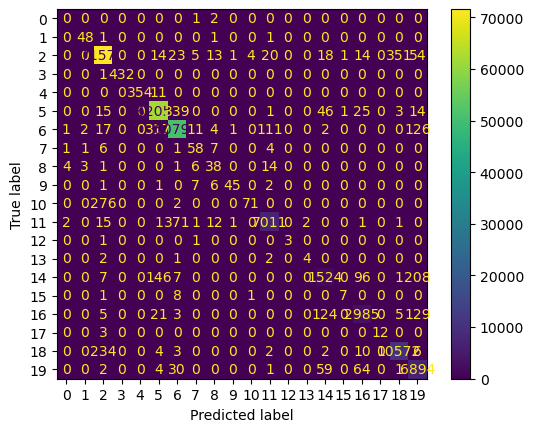

In [21]:
# 테스트 데이터에 대해 predict 수행
# 모델 성능 - confusion matrix
from sklearn.metrics import accuracy_score
import numpy as np
# make predictions and evaluate
#neural
yhat = predict_stacked_model(stacked_model, x_test_1)
yhat_val = tf.argmax(yhat, axis=1)
acc = accuracy_score(y_test_1, yhat_val)
print('Stacked Test Accuracy: %.4f' % acc)

conf_mat = confusion_matrix(y_true=y_test_1, y_pred=yhat_val)
conf_mat

disp = ConfusionMatrixDisplay(conf_mat)
#disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()